## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [57]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
n_samples = 100000
r_value = 3.8
sigma_2_value = 0.3**2
phi_value = 10.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps // 50)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,50)])
        return time_serie.reshape(time_serie.shape[0],1), sampled
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[0]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [59]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(4.5, name="r_1"),
            sigma_2 = theano.shared(0.5**2,name="sigma_2_1"),
           phi = theano.shared(10., name="phi_1")
            )
rng = np.random.RandomState(1234)

X_true = p0.rvs(15000,random_state=rng)
print X_true

[[  0.04242916]
 [  1.63307333]
 [ 16.22144311]
 ..., 
 [  0.06894197]
 [  2.86900618]
 [  8.43420067]]


1.54984658574e-07 22.5638581927
3.41456762855e-29 74.0705071369


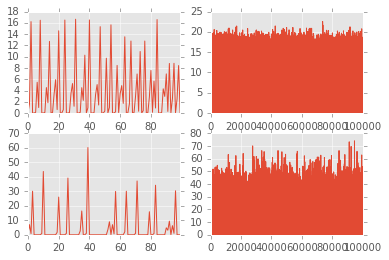

In [60]:
serie1 = p0.rvs(n_samples).ravel()
serie2 = p1.rvs(n_samples).ravel()
plt.figure(1)
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [63]:
from carl.learning import make_parameterized_classification

X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(shared_sigma_2, np.linspace(3.,4., num=10))],
    random_state=1234)

In [64]:
print X
print y

[[  1.41430549e+00   3.00000000e+00]
 [  4.31454171e-01   3.00000000e+00]
 [  9.21564483e+02   3.00000000e+00]
 ..., 
 [  8.31020822e+00   4.00000000e+00]
 [  1.74235346e-01   4.00000000e+00]
 [  1.45385584e+01   4.00000000e+00]]
[ 0.  0.  0. ...,  1.  1.  1.]


In [65]:
max_len = 50
X0_serie = []
y0_serie = []
X1_serie = []
y1_serie = []

X0 = X[y == 0]
X1 = X[y == 1]
for i in xrange(X0.shape[0]-max_len+1):
    # ensure that is from same time serie
    if X0[i][-1] == X0[i+max_len-1][-1]:
        X0_serie.append(X0[i:i+max_len])
    if X1[i][-1] == X1[i+max_len-1][-1]:
        X1_serie.append(X1[i:i+max_len])
X0_serie = np.array(X0_serie)
X1_serie = np.array(X1_serie)

X0_sere = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
X1_sere = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

X_serie = np.vstack((
     X0_serie,
     X1_serie))
y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
y_serie[X0_serie.shape[0]:] = 1


In [66]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = Sequential()
model.add(GRU(10,input_shape=(max_len,2)))
model.add(Dense(5,activation='tanh'))
model.add(Dense(1,activation='tanh'))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
from keras_wrapper import KerasClassifier

clf = KerasClassifier(model=model, loss='mean_squared_error', optimizer='sgd', nb_epoch=5, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/5
171s - loss: 0.0383
Epoch 2/5
172s - loss: 0.0010
Epoch 3/5
172s - loss: 6.9324e-04
Epoch 4/5
173s - loss: 5.9228e-04
Epoch 5/5
173s - loss: 5.4682e-04


In [67]:
print clf.predict_proba(X_serie)

[[ 0.00778925]
 [ 0.00686128]
 [ 0.00751776]
 ..., 
 [ 0.99799412]
 [ 0.99760461]
 [ 0.99839491]]


In [68]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=50, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras_wrapper.KerasClassifier object at 0x18a2a750>,
            bins=50, cv='prefit', eps=0.1, method='histogram'),
        random_state=0)

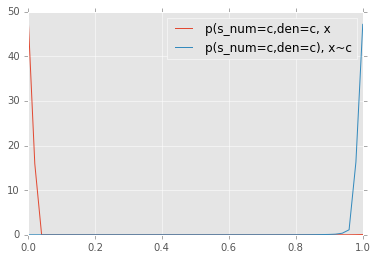

In [69]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0]
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [91]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 10000
def objective(theta, random_state=0):    
    print(theta)
    shared_r.set_value(theta[0])
    #serie1, sampled1 = ricker(r=theta, sigma_2=sigma_2_value,phi=phi_value,n_timesteps=n_samples,start=0.5) 
    serie1 = p0.rvs(n_samples)
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+1))
    X0[:,:-1] = serie1
    X0[:,-1] = theta
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    #serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
    serie2 = p1.rvs(n_samples,random_state=random_state)
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+1))
    X1[:,:-1] = serie2
    X1[:,-1] = 4.5

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)
    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+1))
    X_true_[:,:-1] = X_true
    X_true_[:,-1] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    X_true_serie = X_true_serie[np.random.choice(X_true_serie.shape[0],X_true_serie.shape[0],
                                                replace=False)]
    
    r = ratio.predict(X_true_serie, log=True)
    print r[np.isfinite(r)].shape
    if r[np.isfinite(r)].shape[0] == 0:
        pdb.set_trace()
    value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
            
    return value

In [92]:
from GPyOpt.methods import BayesianOptimization
bounds = [(2.5,4.5)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=250, true_gradients=False)

[ 3.31639396]
(14950,)
[ 4.10157369]
(0,)
> <ipython-input-91-35284211c7e4>(74)objective()
-> value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
(Pdb) r
--Return--
> <ipython-input-91-35284211c7e4>(77)objective()->nan
-> return value
(Pdb) p r
array([-inf, -inf, -inf, ..., -inf, -inf, -inf])
(Pdb) q


BdbQuit: 

In [84]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

[ 3.95363556]
('Approx. MLE =', array([ 3.95363556]))


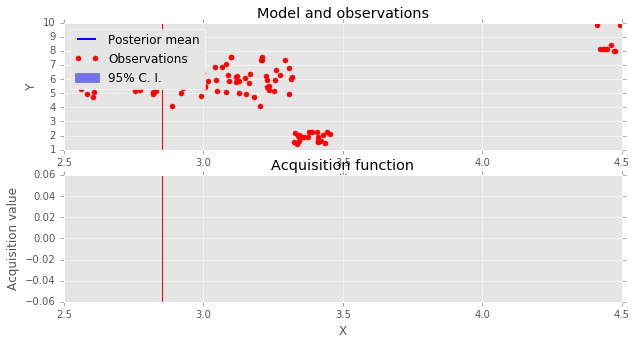

In [77]:
solver.plot_acquisition()

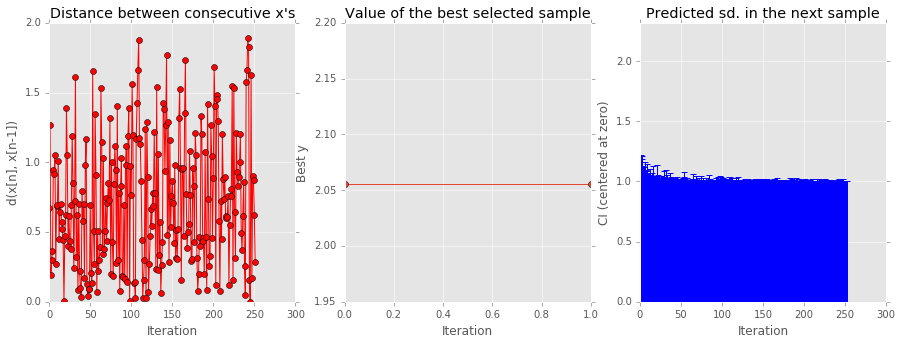

In [78]:
solver.plot_convergence()

In [79]:
from scipy.optimize import minimize
shared_r.set_value(r_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[np.exp(3.)])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

('GP MLE =', array([ 20.08553692]))


In [80]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

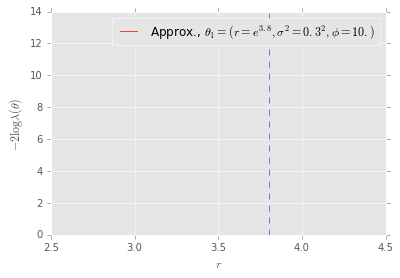

In [81]:
#bounds = [(42.,46.)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=3.8,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

0.09


TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model